<a href="https://colab.research.google.com/github/aldookware/auto-send-tweets/blob/master/Hw1__Naive_Two_Layer_NN_problem_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

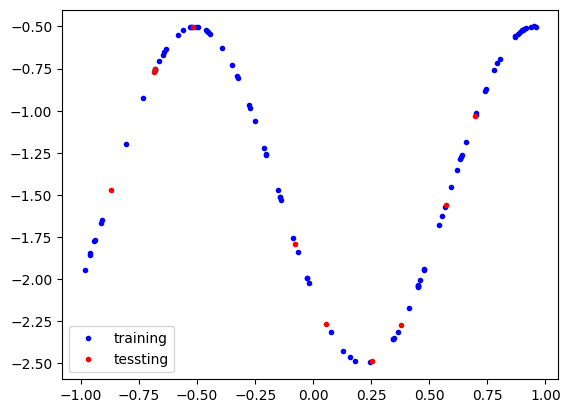

In [ ]:
#@title Prepare a simulated dataset

import numpy as np
import torch
import matplotlib.pyplot as plt
# %matplotlib inline

# number of data points,
num_data = 100
train_data_ratio = 0.9
train_num = int(num_data * train_data_ratio)

# generate data
x_np = np.random.uniform(-1, 1, size=(num_data, 1))  # 1-dim data

# ground truth curve
t = 2.2
w = 4.3
b = -1.5

# use torch for target to match later ops
x_all = torch.from_numpy(x_np).float()
y_all = torch.cos(w * x_all + t) + b

# data split
train_x = x_all[:train_num, :]
train_y = y_all[:train_num, :]
test_x  = x_all[train_num:, :]
test_y  = y_all[train_num:, :]

data = dict([('train_x', train_x), ('train_y', train_y),
             ('test_x', test_x),   ('test_y', test_y)])

plt.plot(data['train_x'].numpy(), data['train_y'].numpy(), '.b', label='training')
plt.plot(data['test_x'].numpy(),  data['test_y'].numpy(),  '.r', label='tessting')
plt.legend()
plt.show()

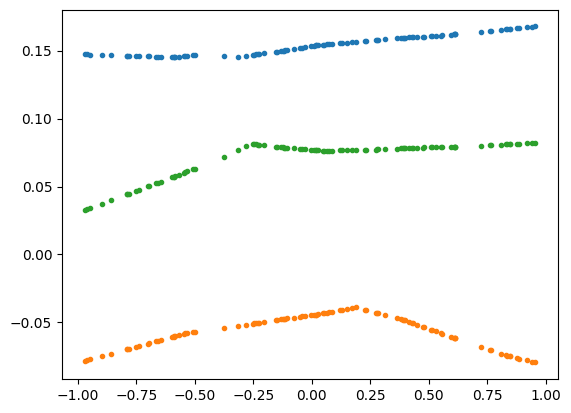

In [ ]:
#@title Hand build a simple MLP

def relu(x):
    ''' Activation Function '''
    return x * (x > 0)

def mlp(params, x):
    '''
    params includes a list of two elements
    indicating the parameter in two layers.
    Each layer's params also have two elements
    including the weight and bias.
    '''
    w1 = params[0][0]  # weight of  layer 1, shape (hidden, in)
    w2 = params[1][0]  # weight of  layer 2, shape (out, hidden)
    b1 = params[0][1]  # bias of  layer 1, shape (hidden,)
    b2 = params[1][1]  # bias of  layer 2, shape (out,)

    h = x @ w1.t() + b1
    h = relu(h)
    y = h @ w2.t() + b2
    return y

def initialize_params(sizes, scale=1e-1, seed=1):
    ''' Initialize the weights of all layers of a linear layer network '''
    '''sizes=[input_dim, hidden_dim, output_dim]'''
    g = torch.Generator(device='cpu')
    g.manual_seed(seed)

    def initialize_layer(m, n, g, scale):
        w = scale * torch.randn(n, m, generator=g)
        b = scale * torch.randn(n,     generator=g)
        # requires_grad will be set during training
        return (w, b)

    return [initialize_layer(m, n, g, scale) for m, n in zip(sizes[:-1], sizes[1:])]

# input_dim, hidden_dim, output_dim
layer_sizes = [1, 50, 1]
# Return a list of tuples of layer weights
params_rnd = initialize_params(layer_sizes, seed=1, scale=1e-1)

# plot some neural networks with random weights.
x_plot = torch.from_numpy(np.random.uniform(-1, 1, size=(100, 1))).float()  # 1-dim data
ypred = mlp(params_rnd, x_plot).detach().numpy()
plt.plot(x_plot.numpy(), ypred, '.')
ypred = mlp(initialize_params(layer_sizes, seed=10), x_plot).detach().numpy()
plt.plot(x_plot.numpy(), ypred, '.')
ypred = mlp(initialize_params(layer_sizes, seed=100), x_plot).detach().numpy()
plt.plot(x_plot.numpy(), ypred, '.')
plt.show()


In [ ]:
#@title Gradient descent

def mse_loss(params, x, y):
    ''' Define the loss function with MSE loss '''
    pred = mlp(params, x)
    return torch.mean((pred - y) ** 2)

#  One step of gradient descent
def gd_step(params, loss_fun, x, y, step_size = 1e-1):
    ''' Calculate gradient and update the parameters '''
    # enable grads
    params_rg = []
    for (w, b) in params:
        w = w.detach().clone().requires_grad_(True)
        b = b.detach().clone().requires_grad_(True)
        params_rg.append((w, b))

    loss = loss_fun(params_rg, x, y)
    loss.backward()

    params_new = []
    for (w, b) in params_rg:
        w_new = (w - step_size * w.grad).detach()
        b_new = (b - step_size * b.grad).detach()
        params_new.append((w_new, b_new))

    return params_new, loss.detach()

# Gradient descent main algorithm
def gd_train(params_initial, loss_fun, model, data, step_size=1e-1, steps=200):
    # initialization
    params = [(w.detach(), b.detach()) for (w, b) in params_initial]
    Losses_train = []
    Losses_test = []
    Pred = []

    # main loop
    for i in range(steps):
        params, loss_train = gd_step(params, loss_fun, data['train_x'], data['train_y'], step_size=step_size)
        with torch.no_grad():
            loss_test = loss_fun(params, data['test_x'], data['test_y'])

        Losses_train.append(loss_train.item())
        Losses_test.append(loss_test.item())
        with torch.no_grad():
            Pred.append(model(params, data['train_x']).detach().clone())
        if i % 100 == 0:
            print('Step {} | Training Loss:{:.2f} | Testing Loss:{:.2f}'.format(i, Losses_train[-1], Losses_test[-1]))

    trajectory = dict([('training_loss', Losses_train),
                       ('testing_loss',  Losses_test),
                       ('train_y_pred',  Pred)])
    return params, trajectory

Step 0 | Training Loss:2.41 | Testing Loss:1.96
Step 100 | Training Loss:0.38 | Testing Loss:0.45
Step 200 | Training Loss:0.27 | Testing Loss:0.31
Step 300 | Training Loss:0.17 | Testing Loss:0.16
Step 400 | Training Loss:0.11 | Testing Loss:0.10
Step 500 | Training Loss:0.07 | Testing Loss:0.05
Step 600 | Training Loss:0.03 | Testing Loss:0.03
Step 700 | Training Loss:0.02 | Testing Loss:0.02
Step 800 | Training Loss:0.01 | Testing Loss:0.01
Step 900 | Training Loss:0.01 | Testing Loss:0.01


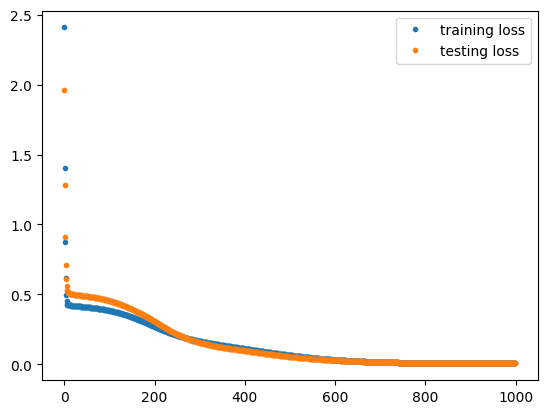

In [ ]:
#@title Main training loop

params_initial = initialize_params(layer_sizes, seed=1, scale=1e-1)
loss_fun = mse_loss
model = mlp
params, trajectory = gd_train(params_initial, loss_fun, model, data, step_size=1e-1, steps=1000)

plt.plot(trajectory['training_loss'], '.', label='training loss')
plt.plot(trajectory['testing_loss'],  '.', label='testing loss')
plt.legend()
plt.show()


In [ ]:
# Visualize the fitting process
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt

def show_cartoon(data, trajectory):
    # cache numpy arrays once (avoid repeated .numpy() calls)
    tx = data['train_x'].detach().cpu().numpy()
    ty = data['train_y'].detach().cpu().numpy()
    preds = [p.detach().cpu().numpy() for p in trajectory['train_y_pred']]

    step = 10
    n_frames = max(1, min(len(preds) // step, 100))
    fig, ax = plt.subplots()
    sc_truth = ax.scatter(tx, ty, color='b', s=10, label='Ground Truth')
    sc_pred = ax.scatter(tx, preds[0], color='r', s=10, label='Training Prediction')

    ax.set_xlim(-1, 1)
    ax.set_ylim(-3, 0)
    ax.legend(loc='upper right')

    def animate(frame_num):
        idx = frame_num * step
        sc_pred.set_offsets(np.c_[tx, preds[idx].reshape(-1)])
        return (sc_pred,)

    anim = FuncAnimation(fig, animate, frames=n_frames, interval=60, blit=False)
    return fig, anim

fig, anim = show_cartoon(data, trajectory)

html = HTML(anim.to_jshtml())
plt.close(fig)
html
